# SUPNIM × Vela — Régression (Niveau Avancé)  
**Date :** 2025-08-27

Ce notebook approfondit les concepts de régression et déroule un **workflow ML en 8 étapes** à partir d’un dataset *type Boston Housing* (version pédagogique incluse localement).  
Objectifs : savoir **choisir le bon modèle**, **évaluer correctement**, et **expliquer** les résultats.



## 🎯 Objectifs pédagogiques
- Connaître les **familles de modèles de régression** (linéaire, régularisés, non‑linéaires, ensembles).
- Savoir **quand utiliser** un modèle linéaire vs non‑linéaire.
- Maîtriser un **workflow ML** clair en 8 étapes (de la formulation au modèle entraîné).
- Pratiquer **feature engineering**, **pipelines**, **validation croisée** et **recherche d’hyperparamètres**.
- Diagnostiquer **overfitting/underfitting** et expliquer le **compromis biais–variance**.
- Mesurer **MAE, RMSE, R²** et rédiger une **interprétation business**.



## 🧭 Panorama des modèles de régression (antisèche)
| Famille | Modèle | Quand l'utiliser | Points d'attention |
|---|---|---|---|
| **Linéaire** | Moindres carrés (OLS) | Relation approx. linéaire, baseline rapide, interprétable | Sensible aux outliers |
| **Régularisés** | Ridge (L2), LASSO (L1), ElasticNet | Beaucoup de features, multicolinéarité | Choix d'alpha via CV, LASSO fait de la sélection |
| **Polynomiaux** | PolyFeatures + Linéaire | Courbes douces/monotones | Risque d'overfit si degré trop élevé |
| **Arbres** | DecisionTreeRegressor | Interactions non‑linéaires, règles explicites | Overfit facile, régler la profondeur |
| **Ensembles** | RandomForest, GradientBoosting | Non‑linéarités + robustesse | Moins interprétables, tuning nécessaire |
| **kNN** | KNeighborsRegressor | Données peu bruitées, structure locale | Sensible au scale et au choix de k |



## 🧪 Métriques à retenir
- **MAE** : erreur moyenne absolue (robuste, interprétable en unité cible)  
- **RMSE** : racine de l'erreur quadratique moyenne (pénalise gros écarts)  
- **R²** : proportion de variance expliquée (attention au R² entraînement trop élevé → surapprentissage)



# Les 8 étapes d’un projet ML (fil rouge)
1. **Problème & métriques** (cadre business, cible, succès)  
2. **Données** (chargement, dictionnaire, qualité)  
3. **EDA** (exploration, corrélations, outliers)  
4. **Préparation** (split, imputation, scaling, features)  
5. **Modélisation baseline** (linéaire)  
6. **Validation croisée & tuning** (GridSearchCV)  
7. **Évaluation finale & interprétation** (importances, résidus)  
8. **(Déploiement – aperçu)** sauvegarde du modèle + exemple d’API



## Étape 1–2) Imports, chargement & définition du problème
**Problème :** prédire **MEDV** (prix médian des maisons) à partir des variables explicatives.  
**Métriques :** MAE, RMSE, R².


## 📊 Description du dataset — Boston Housing (version pédagogique)

Ce dataset contient **506 observations** de logements dans la région de Boston.  
L’objectif est de prédire la **valeur médiane des maisons (MEDV, en milliers de dollars)** en fonction de plusieurs variables socio-économiques et environnementales.

| Variable | Description |
|----------|-------------|
| **CRIM** | Taux de criminalité par habitant par ville |
| **ZN** | Proportion de terrains résidentiels zonés pour des lots de plus de 25 000 sq.ft. |
| **INDUS** | Proportion d’acres non-commerciaux (zones industrielles) par ville |
| **CHAS** | Variable fictive indiquant si la parcelle est bordée par la rivière Charles (1 = oui, 0 = non) |
| **NOX** | Concentration en oxyde nitrique (pollution de l’air, en parties par 10 millions) |
| **RM** | Nombre moyen de pièces par logement |
| **AGE** | Proportion de logements occupés par leur propriétaire construits avant 1940 |
| **DIS** | Distance pondérée aux cinq centres d’emploi de Boston |
| **RAD** | Indice d’accessibilité aux autoroutes radiales |
| **TAX** | Taux d’imposition foncière par 10 000 $ |
| **PTRATIO** | Ratio élèves/enseignant par ville |
| **B** | 1000 × (Bk – 0.63)² où Bk = proportion de résidents afro-américains |
| **LSTAT** | Pourcentage de la population à statut socio-économique faible |
| **MEDV** | Valeur médiane des logements occupés par leur propriétaire (en milliers de $) — **variable cible** |

---

### Remarques :
- **Features numériques** : toutes sauf `CHAS` (variable binaire).  
- **Target** : `MEDV` (continuous).  
- **Utilité pédagogique** : permet d’illustrer la régression linéaire, polynomiale, régularisée et les modèles non-linéaires (arbres, forêts, boosting).  
- **Problèmes**


In [1]:

import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import joblib

from sklearn.datasets import fetch_openml

boston = fetch_openml(name="boston", version=1, as_frame=True)
df = boston.frame
df.head()


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2



## Étape 3) EDA rapide


In [2]:
# Harmoniser en MAJUSCULES (OpenML renvoie en minuscules)
df.columns = [c.upper() for c in df.columns]

TARGET = "MEDV"
FEATURES = [c for c in df.columns if c != TARGET]

print("✅ Chargé :", df.shape, "lignes/colonnes")
display(df.head(3))

print("\n🔎 Questions à se poser (note-les) :")
print("1) La cible MEDV est-elle raisonnablement continue ?")
print("2) Quelles features semblent corrélées (positif/négatif) avec MEDV ?")
print("3) Variables potentiellement redondantes (multicolinéarité) ?")
print("4) Outliers évidents ? Distribution asymétrique ?")

✅ Chargé : (506, 14) lignes/colonnes


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7



🔎 Questions à se poser (note-les) :
1) La cible MEDV est-elle raisonnablement continue ?
2) Quelles features semblent corrélées (positif/négatif) avec MEDV ?
3) Variables potentiellement redondantes (multicolinéarité) ?
4) Outliers évidents ? Distribution asymétrique ?


### 3-1 Vue d’ensemble rapide

In [3]:

df.shape, df.isna().sum().sum(), df.describe()


((506, 14),
 0,
              CRIM          ZN       INDUS         NOX          RM         AGE  \
 count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
 mean     3.613524   11.363636   11.136779    0.554695    6.284634   68.574901   
 std      8.601545   23.322453    6.860353    0.115878    0.702617   28.148861   
 min      0.006320    0.000000    0.460000    0.385000    3.561000    2.900000   
 25%      0.082045    0.000000    5.190000    0.449000    5.885500   45.025000   
 50%      0.256510    0.000000    9.690000    0.538000    6.208500   77.500000   
 75%      3.677083   12.500000   18.100000    0.624000    6.623500   94.075000   
 max     88.976200  100.000000   27.740000    0.871000    8.780000  100.000000   
 
               DIS         TAX     PTRATIO           B       LSTAT        MEDV  
 count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000  
 mean     3.795043  408.237154   18.455534  356.674032   12.653063   22.532806  
 

👀 Types & valeurs manquantes


CRIM        float64
ZN          float64
INDUS       float64
CHAS       category
NOX         float64
RM          float64
AGE         float64
DIS         float64
RAD        category
TAX         float64
PTRATIO     float64
B           float64
LSTAT       float64
MEDV        float64
dtype: object


Manquants total: 0


,count,mean,std,min,25%,50%,75%,max
CRIM,506.0,3.613524,8.601545,0.00632,0.082045,0.25651,3.677083,88.9762
ZN,506.0,11.363636,23.322453,0.00000,0.000000,0.00000,12.500000,100.0000
INDUS,506.0,11.136779,6.860353,0.46000,5.190000,9.69000,18.100000,27.7400
NOX,506.0,0.554695,0.115878,0.38500,0.449000,0.53800,0.624000,0.8710
RM,506.0,6.284634,0.702617,3.56100,5.885500,6.20850,6.623500,8.7800
AGE,506.0,68.574901,28.148861,2.90000,45.025000,77.50000,94.075000,100.0000
DIS,506.0,3.795043,2.105710,1.12960,2.100175,3.20745,5.188425,12.1265
TAX,506.0,408.237154,168.537116,187.00000,279.000000,330.00000,666.000000,711.0000
PTRATIO,506.0,18.455534,2.164946,12.60000,17.400000,19.05000,20.200000,22.0000
B,506.0,356.674032,91.294864,0.32000,375.377500,391.44000,396.225000,396.9000


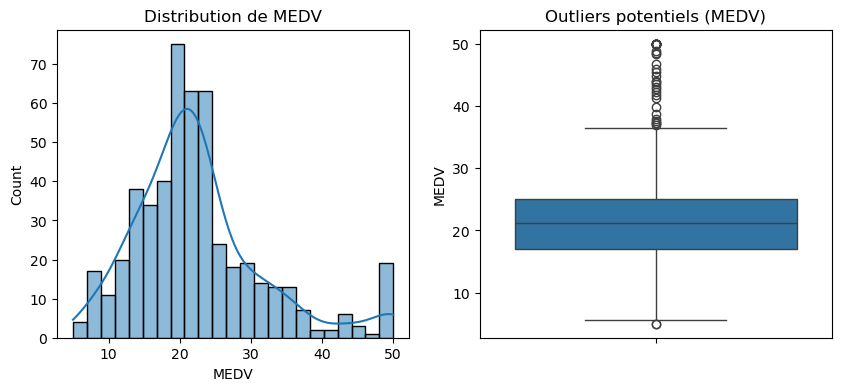

In [4]:
print("👀 Types & valeurs manquantes")
display(df.dtypes)
print("\nManquants total:", int(df.isna().sum().sum()))
display(df.describe().T)

# Petite vue de la distribution de la cible
fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.histplot(df[TARGET], kde=True, ax=ax[0])
ax[0].set_title("Distribution de MEDV")
sns.boxplot(y=df[TARGET], ax=ax[1])
ax[1].set_title("Outliers potentiels (MEDV)")
plt.show()


### 3-2 Corrélations (Pearson & Spearman) + Top variables

#### 📌 Corrélation de Pearson : pourquoi et comment l’interpréter ?

La **corrélation de Pearson** mesure la force et la direction d’une relation linéaire entre deux variables.  
Sa valeur varie entre **-1 et +1** :  

- **+1** → corrélation parfaitement positive (si X augmente, Y augmente toujours)  
- **-1** → corrélation parfaitement négative (si X augmente, Y diminue toujours)  
- **0** → pas de relation linéaire claire  

##### 🔎 Pourquoi c’est utile ?
- Cela permet de repérer **quelles variables sont liées à la variable cible** (ici `MEDV`, le prix des maisons).  
- Cela met aussi en évidence des **relations entre variables explicatives** (multicolinéarité).  
- Cela aide à **sélectionner les variables les plus pertinentes** pour construire le modèle.

##### ✅ Comment interpréter ?
- Une variable avec une forte corrélation (positive ou négative) avec `MEDV` sera probablement **prédictive** du prix des maisons.  
- Si deux variables sont **fortement corrélées entre elles**, elles apportent une information redondante (risque de multicolinéarité).  

👉 En résumé : la corrélation nous donne une **première idée des relations dans les données**, avant même d’entraîner un modèle.


In [5]:

corr = df.corr(numeric_only=True)["MEDV"].sort_values(ascending=False)
corr


MEDV       1.000000
RM         0.695360
ZN         0.360445
B          0.333461
DIS        0.249929
AGE       -0.376955
CRIM      -0.388305
NOX       -0.427321
TAX       -0.468536
INDUS     -0.483725
PTRATIO   -0.507787
LSTAT     -0.737663
Name: MEDV, dtype: float64

,pearson,spearman
LSTAT,-0.737663,-0.852914
RM,0.695360,0.633576
PTRATIO,-0.507787,-0.555905
INDUS,-0.483725,-0.578255
TAX,-0.468536,-0.562411
NOX,-0.427321,-0.562609
CRIM,-0.388305,-0.558891
AGE,-0.376955,-0.547562
ZN,0.360445,0.438179
B,0.333461,0.185664


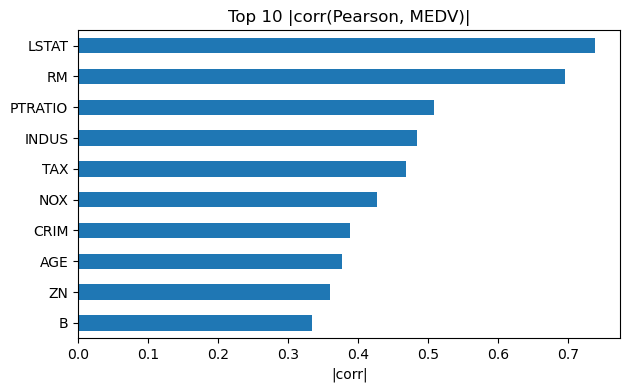


🧭 Guidage :
- RM, LSTAT, PTRATIO, NOX, DIS, TAX, CRIM sont en général influents sur MEDV.
- Compare Pearson vs Spearman : si Spearman diffère beaucoup, il y a peut-être une relation non linéaire/monotone.


In [6]:
# Corrélations vs cible
pearson = df.corr(numeric_only=True)[TARGET].drop(TARGET).sort_values(key=np.abs, ascending=False)
spearman = df.corr(method="spearman", numeric_only=True)[TARGET].drop(TARGET).sort_values(key=np.abs, ascending=False)

corr_tab = pd.DataFrame({
    "pearson": pearson,
    "spearman": spearman
}).sort_values("pearson", key=np.abs, ascending=False)
display(corr_tab)

# Barplot des corrélations (absolues) top 10
topk = corr_tab["pearson"].abs().head(10).index.tolist()
plt.figure(figsize=(7,4))
(corr_tab.loc[topk, "pearson"].abs().sort_values()).plot.barh()
plt.title("Top 10 |corr(Pearson, MEDV)|")
plt.xlabel("|corr|")
plt.show()

print("\n🧭 Guidage :")
print("- RM, LSTAT, PTRATIO, NOX, DIS, TAX, CRIM sont en général influents sur MEDV.")
print("- Compare Pearson vs Spearman : si Spearman diffère beaucoup, il y a peut-être une relation non linéaire/monotone.")


### 3-3 Heatmap ciblée + VIF (multicolinéarité)

### 📌 Qu’est-ce que le VIF (Variance Inflation Factor) ?

Quand on construit un modèle de régression, on utilise plusieurs variables (features) pour prédire la cible.  
Parfois, certaines variables racontent **presque la même histoire**. Exemple :  
- le **taux de taxe foncière (TAX)** et  
- l’**accessibilité aux autoroutes (RAD)**  

Dans Boston Housing, ces deux variables sont très liées.  
➡️ Du coup, le modèle "s'embrouille" car il ne sait pas quelle variable est vraiment importante.

Le **VIF (Variance Inflation Factor)** est un indicateur qui permet de **mesurer ce problème**.  

#### Comment lire le VIF ?
- **VIF ≈ 1** → pas de problème, la variable apporte une information unique.  
- **VIF entre 1 et 5** → un peu de redondance, mais acceptable.  
- **VIF > 5** → attention, la variable répète beaucoup l’information d’autres variables.  
- **VIF > 10** → gros souci de redondance, il faut réfléchir à retirer ou transformer la variable.  

#### Pourquoi c’est important ?
- Si trop de variables disent la même chose → le modèle peut devenir **instable** et difficile à interpréter.  
- En repérant les VIF trop élevés, on peut **simplifier** le modèle et améliorer ses prédictions.  

👉 Retenez juste : le VIF sert à **détecter si deux variables se marchent sur les pieds**.


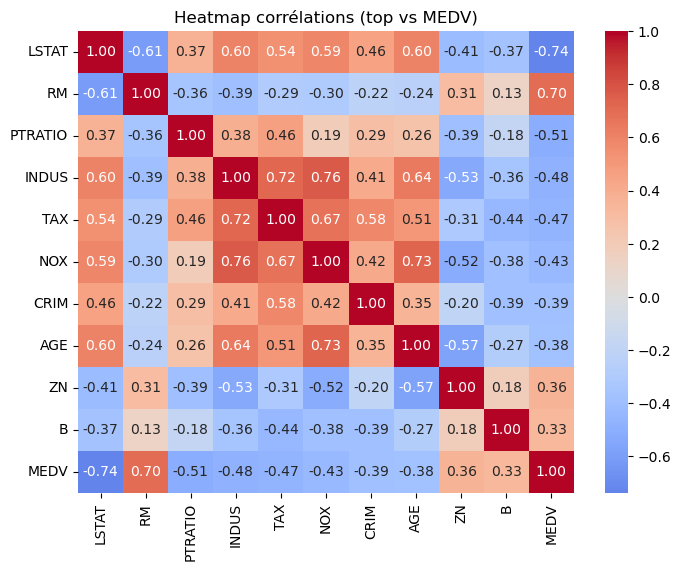

NOX        3.937118
INDUS      3.487963
TAX        3.402682
LSTAT      2.924108
AGE        2.814839
ZN         1.897042
RM         1.844611
PTRATIO    1.709877
CRIM       1.637537
B          1.338246
Name: VIF, dtype: float64


🧭 Guidage :
- VIF > 5–10 = multicolinéarité notable (ex: TAX, RAD, INDUS sont souvent corrélées).
- Réfléchis à retirer/combiner des variables redondantes avant le modèle linéaire régulier.


In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Heatmap sur les 10 plus corrélées (en incluant la cible)
cols_heat = topk + [TARGET]
plt.figure(figsize=(8,6))
sns.heatmap(df[cols_heat].corr(), annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Heatmap corrélations (top vs MEDV)")
plt.show()

# VIF sur les features (sans la cible)
X_top = df[topk].copy()
X_top = (X_top - X_top.mean())/X_top.std(ddof=0)  # standardisation pour VIF

vif_vals = pd.Series(
    [variance_inflation_factor(X_top.values, i) for i in range(X_top.shape[1])],
    index=X_top.columns, name="VIF"
).sort_values(ascending=False)

display(vif_vals)

print("\n🧭 Guidage :")
print("- VIF > 5–10 = multicolinéarité notable (ex: TAX, RAD, INDUS sont souvent corrélées).")
print("- Réfléchis à retirer/combiner des variables redondantes avant le modèle linéaire régulier.")


### 3-4 Relation feature↔cible avec LOWESS (détecter non-linéarités)

### 🔎 Qu’est-ce qu’un LOWESS plot ?

Un **LOWESS plot** (Locally Weighted Scatterplot Smoothing) est un nuage de points accompagné d’une **courbe lissée**.  

- Les **points** représentent les observations réelles (ex : nombre de pièces vs prix des maisons).  
- La **courbe** montre la tendance générale entre la variable explicative et la cible, sans imposer une forme stricte (comme une droite linéaire).  

### Pourquoi c’est utile ?
- Cela permet de **voir si la relation est vraiment linéaire** ou si elle suit une forme plus courbée.  
- Si la courbe n’est pas une ligne droite, cela indique que **la régression linéaire simple risque d’être trop limitée**.  
- C’est un outil visuel très pratique pour décider :  
  - d’ajouter des **transformations de variables** (ex : log, carré),  
  - ou d’utiliser des **modèles non-linéaires** (arbres, random forest, etc.).  

👉 En résumé : le LOWESS plot aide à **détecter la vraie forme de la relation** entre une variable et la cible.


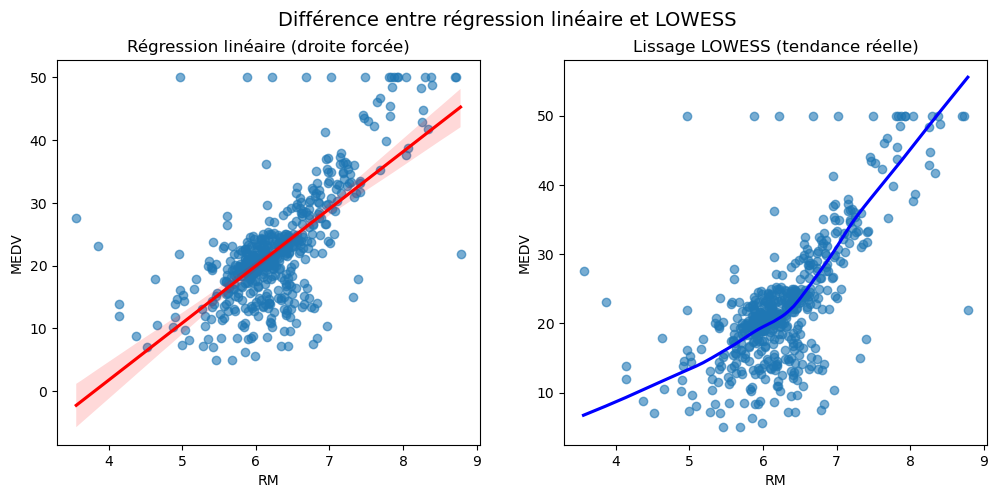

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Exemple avec RM (nombre moyen de pièces) vs MEDV
fig, ax = plt.subplots(1, 2, figsize=(12,5))

# 1) Régression linéaire forcée
sns.regplot(data=df, x="RM", y="MEDV", scatter_kws={"alpha":0.6}, line_kws={"color":"red"}, ax=ax[0])
ax[0].set_title("Régression linéaire (droite forcée)")

# 2) Lissage LOWESS
sns.regplot(data=df, x="RM", y="MEDV", lowess=True,
            scatter_kws={"alpha":0.6}, line_kws={"color":"blue"}, ax=ax[1])
ax[1].set_title("Lissage LOWESS (tendance réelle)")

plt.suptitle("Différence entre régression linéaire et LOWESS", fontsize=14)
plt.show()


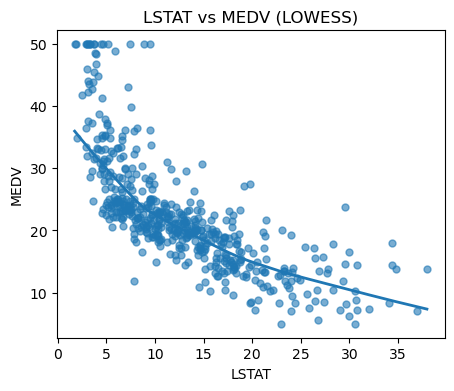

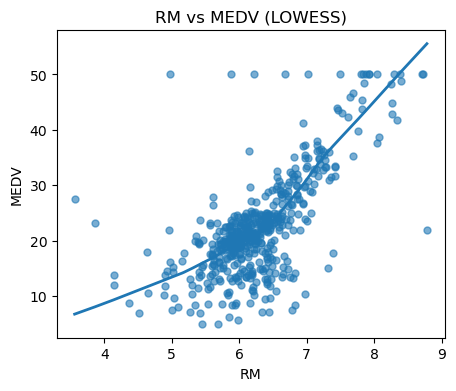

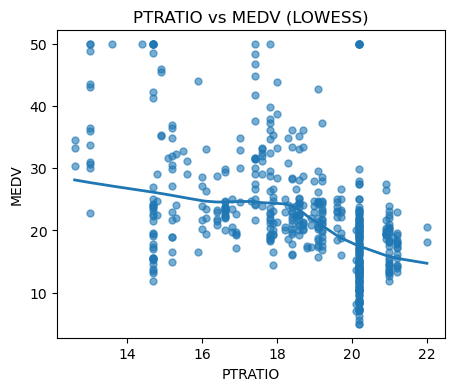

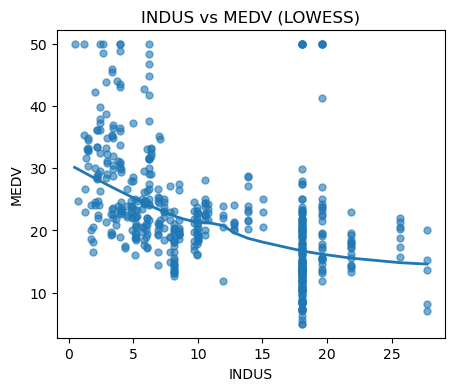

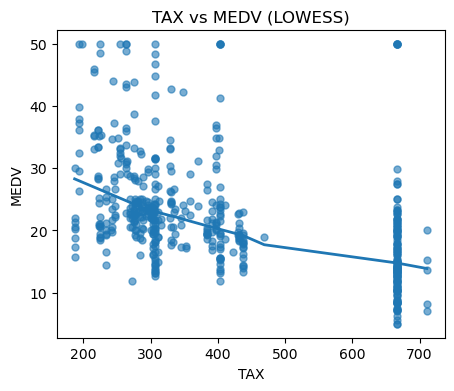

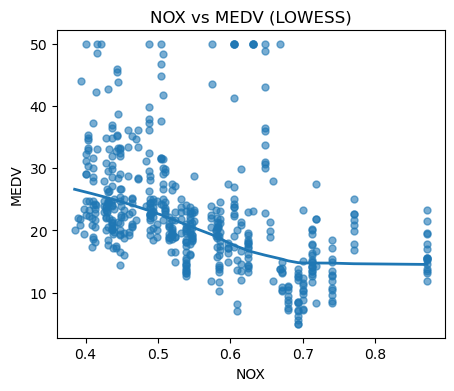


🧭 Guidage :
- Courbe non parfaitement linéaire ? Pense aux features polynomiales ou à un modèle non-linéaire (arbres/ensembles).
- Hétéroscédasticité visible (dispersion qui augmente) ? Regarde les résidus après un 1er modèle.


In [25]:
# LOWESS via seaborn.regplot(lowess=True)
for col in topk[:6]:  # pour ne pas inonder l'output
    plt.figure(figsize=(5,4))
    sns.regplot(data=df, x=col, y=TARGET, lowess=True,
                scatter_kws={"s":25, "alpha":0.6}, line_kws={"lw":2})
    plt.title(f"{col} vs {TARGET} (LOWESS)")
    plt.show()

print("\n🧭 Guidage :")
print("- Courbe non parfaitement linéaire ? Pense aux features polynomiales ou à un modèle non-linéaire (arbres/ensembles).")
print("- Hétéroscédasticité visible (dispersion qui augmente) ? Regarde les résidus après un 1er modèle.")


## 📊 Interprétation des relations (LOWESS plots)

Voici ce que l’on observe sur les principales variables explicatives par rapport à la cible **MEDV (prix médian des maisons)** :

---

### 🔹 LSTAT (% population défavorisée) vs MEDV
- Relation **très clairement décroissante**.  
- Quand `LSTAT` augmente, les prix chutent fortement, surtout entre 0 et 10 %.  
- Ensuite la baisse se poursuit mais de manière plus douce.  
👉 **Conclusion** : le statut socio-économique d’un quartier est un facteur majeur qui influence les prix.

---

### 🔹 RM (nombre moyen de pièces) vs MEDV
- Relation **fortement croissante** : plus il y a de pièces, plus la maison vaut cher.  
- La relation semble légèrement courbe (non parfaitement linéaire).  
👉 **Conclusion** : le nombre de pièces est une des variables **les plus prédictives**.

---

### 🔹 PTRATIO (ratio élèves/enseignant) vs MEDV
- Relation **légèrement décroissante** : plus les classes sont chargées, plus les prix sont bas.  
- Effet moins marqué que `RM` ou `LSTAT`.  
👉 **Conclusion** : la qualité perçue du système scolaire joue un rôle, mais secondaire.

---

### 🔹 INDUS (% zone industrielle) vs MEDV
- Relation **décroissante** : plus il y a d’industries, plus les prix chutent.  
- L’effet est fort au début puis se stabilise.  
👉 **Conclusion** : la proximité d’industries réduit l’attractivité des logements.

---

### 🔹 TAX (taux de taxe foncière) vs MEDV
- Relation **décroissante**, mais plus dispersée.  
- Pas aussi net que `RM` ou `LSTAT`.  
👉 **Conclusion** : la fiscalité locale a un effet sur les prix, mais combinée à d’autres facteurs (comme `RAD`).

---

### 🔹 NOX (pollution de l’air) vs MEDV
- Relation **décroissante** : plus la pollution augmente, plus les prix baissent.  
- L’effet est fort entre 0.3 et 0.6 puis se stabilise.  
👉 **Conclusion** : la pollution de l’air a un impact négatif sur la valeur des logements.

---

## 🌍 Synthèse
- **Les deux variables les plus fortes** :  
  - `RM` (plus de pièces → prix plus élevé),  
  - `LSTAT` (plus de pauvreté → prix plus bas).  
- Variables secondaires mais cohérentes : `NOX`, `TAX`, `PTRATIO`, `INDUS`.  
- **Plusieurs relations ne sont pas linéaires** → il faudra tester :  
  - des transformations (ex : `log(LSTAT)`, `RM²`),  
  - ou des modèles non-linéaires (arbres, random forest, boosting).

---


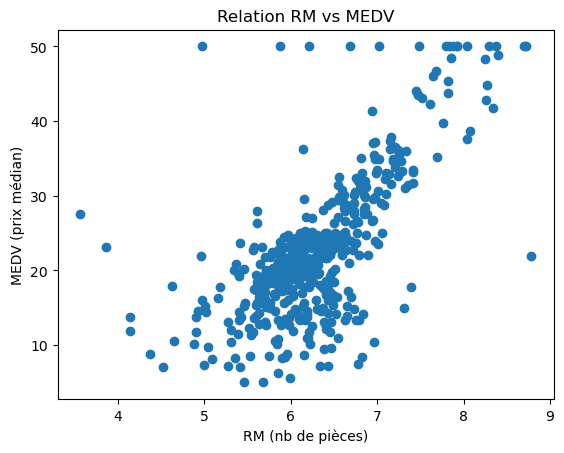

In [9]:

plt.scatter(df["RM"], df["MEDV"])
plt.xlabel("RM (nb de pièces)")
plt.ylabel("MEDV (prix médian)")
plt.title("Relation RM vs MEDV")
plt.show()


### 3-5 Distributions & outliers (top variables)


#### 📌 Qu’est-ce qu’un outlier et pourquoi c’est important ?

Un **outlier** (ou valeur extrême) est une observation qui est très différente de la majorité des données.  
Par exemple :  
- un quartier avec un **taux de criminalité extrêmement haut**,  
- une maison avec **beaucoup plus de pièces** que la moyenne,  
- une taxe foncière **très différente** des autres villes.

#### 🔎 Pourquoi les outliers comptent ?
- Dans une **régression linéaire**, un seul outlier peut **tirer la droite de régression** et fausser les coefficients.  


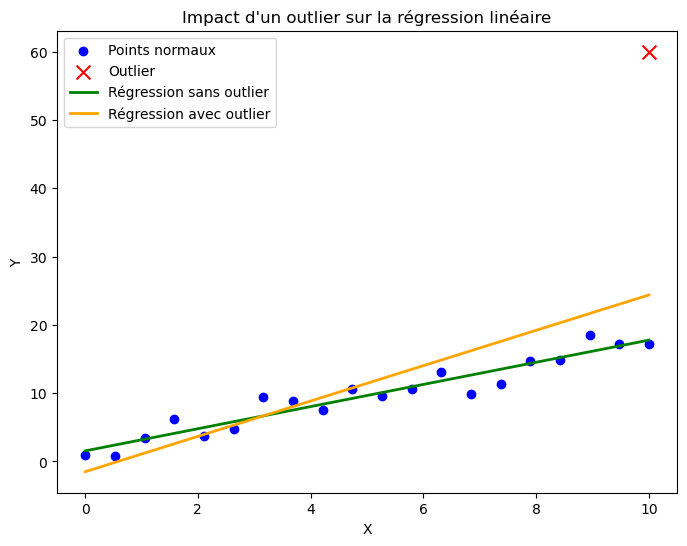

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Jeu de données simple : relation linéaire y = 2x + bruit
np.random.seed(42)
X = np.linspace(0, 10, 20)
y = 2*X + np.random.normal(0, 2, size=len(X))

# Ajouter un outlier extrême
X_outlier = np.append(X, [10])
y_outlier = np.append(y, [60])  # très loin de la tendance

# Reshape pour sklearn
X_reshaped = X.reshape(-1, 1)
X_outlier_reshaped = X_outlier.reshape(-1, 1)

# Modèle sans outlier
model_clean = LinearRegression().fit(X_reshaped, y)
line_clean = model_clean.predict(X_reshaped)

# Modèle avec outlier
model_outlier = LinearRegression().fit(X_outlier_reshaped, y_outlier)
line_outlier = model_outlier.predict(X_outlier_reshaped)

# Tracé
plt.figure(figsize=(8,6))
plt.scatter(X, y, label="Points normaux", color="blue")
plt.scatter([10], [60], label="Outlier", color="red", s=100, marker="x")
plt.plot(X, line_clean, label="Régression sans outlier", color="green", linewidth=2)
plt.plot(X_outlier, line_outlier, label="Régression avec outlier", color="orange", linewidth=2)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Impact d'un outlier sur la régression linéaire")
plt.legend()
plt.show()


#### 🎯 Impact des outliers sur une régression linéaire

Le graphique ci-dessus montre que :

- Quand on entraîne un modèle **sans l’outlier**, la droite (verte) suit bien la tendance générale des données.  
- Quand on **ajoute un seul point extrême** (rouge), la droite (orange) est complètement déformée et ne reflète plus la réalité.  

👉 **Un seul outlier peut fausser tout un modèle linéaire.**  
C’est pour ça qu’en EDA, on prend toujours le temps de :  
- détecter les outliers,  
- décider s’il faut les garder, les transformer, ou utiliser un modèle plus robuste.


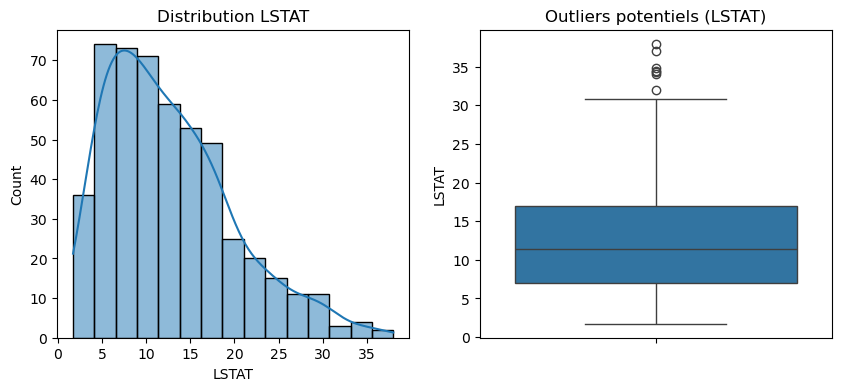

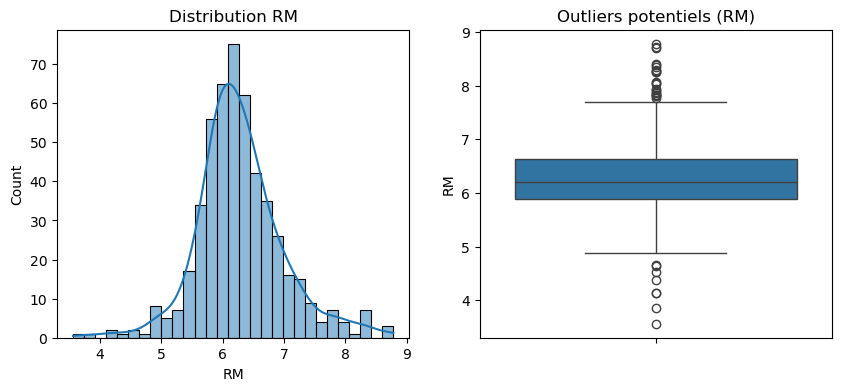

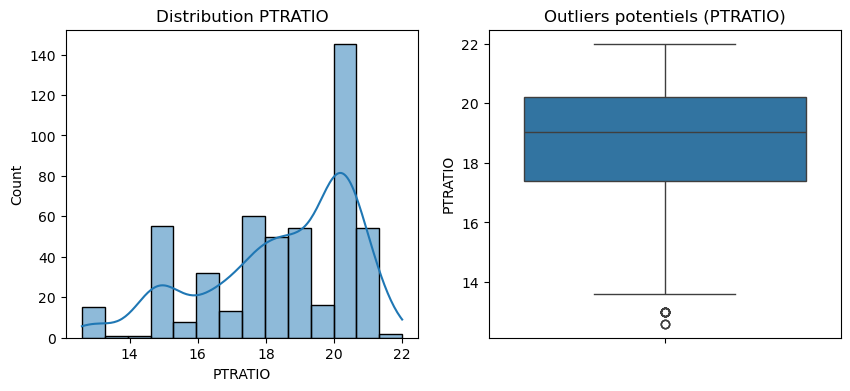

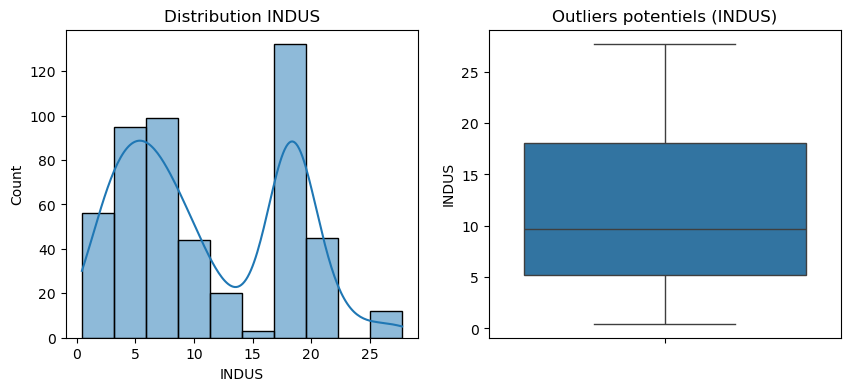

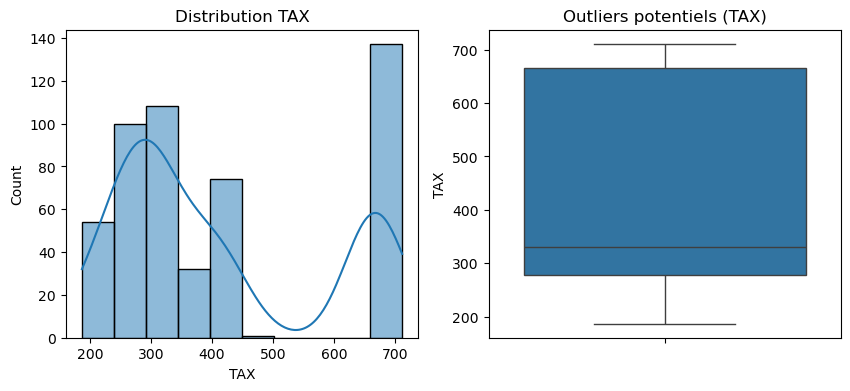

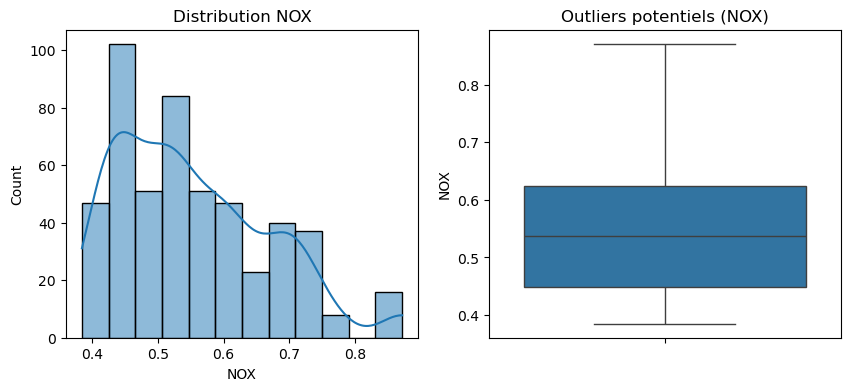


🧭 Guidage :
- Outliers extrêmes ? Envisage winsorisation, log-transform (ex: CRIM), ou modèles robustes.
- Variables très asymétriques (CRIM, LSTAT, DIS, TAX) : transformations possibles (log, sqrt).


In [27]:
# Distributions & boxplots des top variables
for col in topk[:6]:
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    sns.histplot(df[col], kde=True, ax=ax[0])
    ax[0].set_title(f"Distribution {col}")
    sns.boxplot(y=df[col], ax=ax[1])
    ax[1].set_title(f"Outliers potentiels ({col})")
    plt.show()

print("\n🧭 Guidage :")
print("- Outliers extrêmes ? Envisage winsorisation, log-transform (ex: CRIM), ou modèles robustes.")
print("- Variables très asymétriques (CRIM, LSTAT, DIS, TAX) : transformations possibles (log, sqrt).")


#### 📊 Interprétation des distributions & outliers

##### 🔹 LSTAT (% population défavorisée)
- Distribution **asymétrique à droite** (skewed).  
- Quelques quartiers très défavorisés (> 30 %) apparaissent comme outliers.  
👉 Ces valeurs sont plausibles (quartiers pauvres), mais peuvent avoir un impact fort → transformation log possible.

---

##### 🔹 RM (nombre moyen de pièces)
- Distribution proche de la normale, centrée autour de 6.  
- Outliers : maisons très petites (< 4) ou très grandes (> 8).  
👉 Ce sont des cas réels (studios, villas), à garder.

---

##### 🔹 PTRATIO (élèves/professeur)
- Distribution en valeurs discrètes (lié aux systèmes scolaires des villes).  
- Outliers : certaines villes avec classes très réduites (< 14 élèves/prof).  
👉 Ce sont des situations rares mais plausibles, pas des erreurs.

---

##### 🔹 TAX (taux de taxe foncière)
- Distribution multimodale (pics autour de 300 et 700).  
- Plusieurs valeurs extrêmes (près de 700) considérées comme outliers.  
👉 Reflète des politiques fiscales différentes → attention pour les modèles linéaires.

---

##### 🔹 NOX (pollution de l’air)
- Distribution asymétrique (concentrée entre 0.4 et 0.6).  
- Outliers : quelques quartiers très pollués (~0.8).  
👉 Impact négatif fort possible sur la valeur des logements.

---

#### ✅ Synthèse
- **Variables avec outliers marquants :** LSTAT, TAX, NOX.  
- **Distributions asymétriques :** LSTAT, TAX, NOX → transformations (log, sqrt) envisageables.  
- Beaucoup d’outliers sont plausibles (ex : grandes maisons, fiscalité locale) → pas forcément à supprimer.  
- Pour limiter leur effet, on pourra tester :  
  - des **transformations de variables**,  
  - ou des **modèles robustes/non-linéaires** (arbres, random forest, boosting).



## Étape 4) Préparation des données


#### 📌 Étape 4 : Préparation des données

Avant d’entraîner un modèle, il faut préparer les données pour que l’apprentissage soit efficace et juste.

1. **Séparation des données**  
   - On définit la variable cible (`MEDV`, prix médian des maisons).  
   - On définit les variables explicatives (`features`).  
   - On sépare ensuite en deux ensembles :  
     - **Train (80%)** → pour entraîner le modèle  
     - **Test (20%)** → pour évaluer la performance finale du modèle  

2. **Mise à l’échelle des variables (Standardisation)**  
   Les variables n’ont pas toutes la même unité (ex : taux de taxe, pollution, nombre de pièces).  
   → Si on les laisse telles quelles, certaines prendront trop d’importance.  
   → La **standardisation** remet toutes les variables sur une même échelle (moyenne = 0, écart-type = 1).  

👉 Cette étape garantit que notre modèle de régression linéaire va apprendre correctement et ne pas être biaisé par l’échelle des données.


In [11]:
# 1. Définir la cible et les variables explicatives
target = "MEDV"
features = [c for c in df.columns if c != target]
X, y = df[features], df[target]

# 2. Découper en train (80%) et test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Préparer un pipeline simple avec standardisation
preprocess_linear = Pipeline([
    ("scaler", StandardScaler())
])

print("Données prêtes :")
print("Train :", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)

Données prêtes :
Train : (404, 13) (404,)
Test : (102, 13) (102,)



## Étape 5) Baseline linéaire


#### 📌 Étape 5 : Baseline linéaire

Ici, nous entraînons notre premier **modèle de régression linéaire** simple.  
C’est ce qu’on appelle une **baseline** : un modèle de référence, le plus simple possible, qui nous servira à comparer les résultats des prochains modèles.

##### 🔎 Ce que nous faisons
- On entraîne le modèle sur les données **d’entraînement** (train).  
- On prédit les valeurs sur les données **test** (jamais vues pendant l’entraînement).  
- On mesure les performances avec 3 métriques :  
  - **MAE (Mean Absolute Error)** → erreur moyenne en valeur absolue.  
  - **RMSE (Root Mean Squared Error)** → erreur quadratique moyenne (pénalise plus les grosses erreurs).  
  - **R² (coefficient de détermination)** → proportion de la variance expliquée par le modèle (entre 0 et 1).

##### ✅ Interprétation de nos résultats
- **MAE ≈ 3.19** → en moyenne, le modèle se trompe d’environ 3,2 unités sur la prédiction du prix médian.  
- **RMSE ≈ 4.93** → les erreurs les plus fortes sont un peu plus élevées, mais restent dans un ordre raisonnable.  
- **R² ≈ 0.669** → environ **67 % de la variance** du prix des maisons est expliquée par ce modèle linéaire.  
  👉 C’est correct pour un premier modèle de référence, mais il y a encore de la marge pour améliorer.

##### 🔗 Lien avec underfitting et overfitting
- Un modèle trop **simple** (underfitting) n’arriverait pas à capturer les tendances des données.  
- Un modèle trop **complexe** (overfitting) apprendrait "par cœur" et se tromperait sur de nouvelles données.  
- Notre objectif est de rester dans un **juste milieu** : un modèle assez riche pour apprendre les relations, mais qui reste capable de généraliser.


In [12]:

baseline = Pipeline([("prep", preprocess_linear), ("model", LinearRegression())])
baseline.fit(X_train, y_train)
pred = baseline.predict(X_test)

print("Baseline — MAE:", round(mean_absolute_error(y_test, pred),2))
print("Baseline — RMSE:", round(mean_squared_error(y_test, pred, squared=False),2))
print("Baseline — R²:", round(r2_score(y_test, pred),3))


Baseline — MAE: 3.19
Baseline — RMSE: 4.93
Baseline — R²: 0.669


c:\Users\mohamed.beydia\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


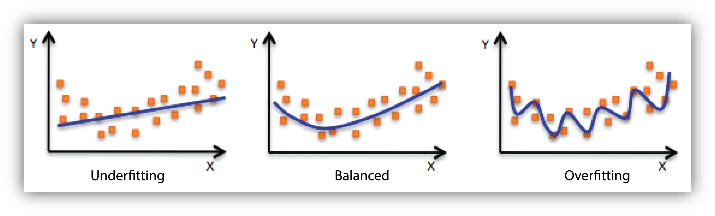

In [35]:
from IPython.display import Image

# Display your local image in Jupyter
Image(filename="mlconcepts_image5.png")



## Étape 6) Validation croisée & tuning (GridSearchCV)


## 📌 Validation des modèles : Train/Test, Validation, et Cross-Validation

### 1. Découpage simple : Train/Test
Traditionnellement, on divise les données en deux parties :
- **Training** : pour entraîner le modèle
- **Testing** : pour évaluer sa performance finale (échantillon "holdout", qu’on garde de côté)

![Train/Test](img/training-validation-test-data-set.png)

👉 Limite : si on a peu de données, on risque d’avoir un découpage "chanceux" ou "malchanceux".

---

### 2. Ajout d’un jeu de Validation
Avec plus de données, on introduit une troisième partie :
- **Training** : apprentissage
- **Validation** : réglage des hyperparamètres et choix du modèle
- **Testing** : évaluation finale, jamais utilisé pendant l’entraînement

👉 Cela permet de mieux comparer plusieurs modèles.

---

### 3. Validation croisée (K-Fold Cross-Validation)
Au lieu de découper une seule fois, on découpe les données en `k` blocs (par ex. 5 folds).  
- On entraîne le modèle `k` fois : à chaque fois un bloc différent sert de **test**, les autres de **train**.  
- On calcule la performance moyenne → beaucoup plus **robuste**.

![K-Fold](img/kfold5.png)

---

### 🔎 Résumé des méthodes de validation
- **Train/Test split** → simple, rapide, mais parfois peu fiable.  
- **Train/Validation/Test** → utile quand on a beaucoup de données et qu’on veut comparer plusieurs modèles.  
- **K-Fold Cross-Validation** → plus fiable, car le modèle est testé plusieurs fois sur différentes partitions.  

👉 Dans notre cours, on utilise la **validation croisée 5-fold**, car elle équilibre robustesse et simplicité.


In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
import numpy as np


# Conversion explicite en float
X_train = X_train.astype(float)
y_train = y_train.astype(float)


# Modèle simple : régression linéaire
model = LinearRegression()

# Validation croisée (5 folds)
scores = cross_val_score(model, X_train, y_train,
                         scoring="neg_root_mean_squared_error",
                         cv=5)

# On prend la moyenne (et l'écart type) des scores
rmse_scores = -scores
print("Scores RMSE (par fold) :", rmse_scores)
print("RMSE moyen :", rmse_scores.mean())
print("Écart type :", rmse_scores.std())


Scores RMSE (par fold) : [4.14750971 5.86588332 4.87168245 4.50382793 4.75856192]
RMSE moyen : 4.829493065236912
Écart type : 0.5748173650240501


#### 📊 Interprétation des résultats de la validation croisée

Avec un simple découpage **train/test split**, on obtient une estimation de la performance du modèle,  
mais cette estimation peut dépendre fortement de la façon dont les données ont été découpées.

Ici, nous avons utilisé une **validation croisée à 5 folds** :  
- Le modèle a été entraîné et testé 5 fois, sur des parties différentes du jeu de données.  
- Les erreurs RMSE par fold sont : [4.15, 5.87, 4.87, 4.50, 4.76].  
- **RMSE moyen = 4.83**, avec un **écart type = 0.57**.

#### ✅ Ce que ça signifie
- Le modèle est **relativement stable** : les erreurs par fold ne varient pas énormément.  
- Le RMSE moyen (4.83) est proche de celui obtenu avec un simple train/test (≈ 4.93),  
  mais ici nous avons une estimation **plus robuste et plus fiable** de la performance.  
- L’écart type (0.57) est faible → le modèle généralise de manière assez cohérente.  

👉 En résumé : la validation croisée confirme que notre **baseline linéaire est correcte**  
et qu’elle explique une bonne partie de la variance, mais avec encore une marge d’amélioration possible.



## Étape 7) Évaluation finale & interprétation


#### 📌 Étape 7 : Évaluation finale & benchmark des modèles

Jusqu’ici, nous avons construit un **modèle baseline** (régression linéaire simple) et validé sa stabilité.  
Maintenant, faisons deux choses :  
1. Comparer différents algorithmes de régression sur notre dataset.  
2. Observer l’impact de l’**analyse exploratoire (EDA)** sur les performances :  
   - Modèle naïf = on prend toutes les variables sans réfléchir.  
   - Modèle guidé = on choisit seulement les variables pertinentes (par ex. `RM`, `LSTAT`, `PTRATIO`), identifiées lors de l’EDA.  

#### 🔎 Pourquoi c’est important ?
Beaucoup de gens lancent un modèle “par défaut” sans se soucier des données.  
Mais en pratique, **l’EDA et la sélection de variables expliquent une grande partie du succès**.  
Nous allons donc comparer ces deux approches.

---


In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd

# 🔹 Conversion explicite en float
# Certains modèles sklearn (ex: LinearRegression) attendent des données numériques continues (float).
# Si les colonnes contiennent des types 'object' ou 'int' mal interprétés,
# on obtient une erreur de type "can't multiply sequence by non-int of type 'float'".
# Cette conversion garantit que toutes les features sont bien au bon format.
X_train = X_train.astype(float)
X_test = X_test.astype(float)

# 🔹 Définir nos modèles
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=100),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42, n_estimators=100)
}

results = []

# 🔹 Entraînement et évaluation de chaque modèle
for name, model in models.items():
    model.fit(X_train, y_train)              # Apprentissage du modèle
    y_pred = model.predict(X_test)           # Prédictions sur le test set
    
    # Calcul des métriques
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    
    results.append([name, mae, rmse, r2])

# 🔹 Mettre les résultats dans un tableau clair
results_df = pd.DataFrame(results, columns=["Modèle", "MAE", "RMSE", "R²"])
results_df


c:\Users\mohamed.beydia\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\mohamed.beydia\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\mohamed.beydia\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\mohamed.beydia\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated i

,Modèle,MAE,RMSE,R²
0,Linear Regression,3.189092,4.928602,0.668759
1,Decision Tree,2.394118,3.227395,0.857963
2,Random Forest,2.039539,2.810963,0.892253
3,Gradient Boosting,1.912243,2.491759,0.915334


In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np

# 🔹 Créer de nouvelles features basées sur l'EDA
df_eda = df.copy()
df_eda["LSTAT2"] = df_eda["LSTAT"] ** 2  # capture la non-linéarité

# 🔹 Sélection de variables guidée par l’EDA
# On garde seulement un sous-ensemble jugé pertinent
features_eda = ["RM", "LSTAT", "LSTAT2", "PTRATIO", "NOX"]  
X_eda = df_eda[features_eda].astype(float)
y_eda = df_eda["MEDV"].astype(float)

# Split train/test
X_train_eda, X_test_eda, y_train_eda, y_test_eda = train_test_split(
    X_eda, y_eda, test_size=0.2, random_state=42
)

# 🔹 Modèles à comparer (comme avant)
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=100),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42, n_estimators=100)
}

results_eda = []

for name, model in models.items():
    # Pipeline avec standardisation (important pour la régression linéaire)
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model)
    ])
    
    pipeline.fit(X_train_eda, y_train_eda)
    y_pred = pipeline.predict(X_test_eda)
    
    mae = mean_absolute_error(y_test_eda, y_pred)
    rmse = mean_squared_error(y_test_eda, y_pred, squared=False)
    r2 = r2_score(y_test_eda, y_pred)
    
    results_eda.append([name, mae, rmse, r2])

# 🔹 Mettre les résultats dans un tableau
results_eda_df = pd.DataFrame(results_eda, columns=["Modèle", "MAE", "RMSE", "R²"])
results_eda_df


c:\Users\mohamed.beydia\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\mohamed.beydia\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\mohamed.beydia\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\mohamed.beydia\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated i

,Modèle,MAE,RMSE,R²
0,Linear Regression,3.049102,4.692222,0.699771
1,Decision Tree,2.919608,4.402072,0.735753
2,Random Forest,2.227039,3.587706,0.824479
3,Gradient Boosting,2.238934,3.451200,0.837581


### Interprétation : comparaison avant/après EDA

Si on compare les résultats obtenus avec **toutes les variables** (bête et méchant) et ceux obtenus après avoir appliqué les enseignements de l’EDA (sélection de variables pertinentes + ajout de `LSTAT²`), on observe :

- **Régression linéaire :**
  - Avant EDA : RMSE ≈ 4.93, R² ≈ 0.66  
  - Après EDA : RMSE ≈ 4.69, R² ≈ 0.70  
  👉 Les performances se sont améliorées : le modèle explique mieux la variance et fait moins d’erreurs.

- **Autres algorithmes (arbres, forêts, boosting) :**
  - Leur performance a légèrement baissé après la sélection de variables.
  - Cela s’explique par le fait que ces modèles capturent aussi des relations non-linéaires et des interactions complexes.
  - En retirant certaines variables, on perd donc un peu d’information utile pour eux.

⚡ **Conclusion :**  
- L’EDA permet d’orienter le choix et la préparation des variables pour des modèles sensibles comme la régression linéaire.  
- On voit bien qu’une approche guidée par l’analyse des données améliore les résultats, même sans changer d’algorithme.  
- Avec les modèles complexes (arbres, forêts), l’impact est moins positif car ces modèles profitent davantage de la richesse brute des données.  

👉 Moralité : toujours adapter la préparation des données au type de modèle utilisé.


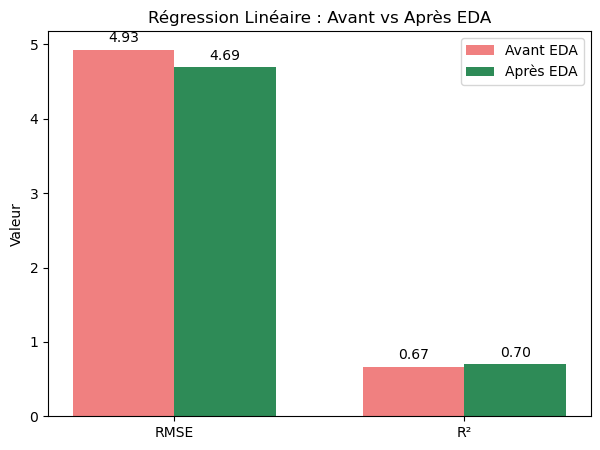

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Résultats (à ajuster avec tes vraies valeurs)
rmse_avant = 4.93
r2_avant = 0.669

rmse_apres = 4.69
r2_apres = 0.700

labels = ["RMSE", "R²"]
avant = [rmse_avant, r2_avant]
apres = [rmse_apres, r2_apres]

x = np.arange(len(labels))  # positions
width = 0.35  # largeur des barres

fig, ax = plt.subplots(figsize=(7,5))
rects1 = ax.bar(x - width/2, avant, width, label="Avant EDA", color="lightcoral")
rects2 = ax.bar(x + width/2, apres, width, label="Après EDA", color="seagreen")

# Titres et labels
ax.set_ylabel("Valeur")
ax.set_title("Régression Linéaire : Avant vs Après EDA")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Annoter les barres
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0,3),  # décalage vertical
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

plt.show()


### Résidus de la régression linéaire : Baseline linéaire (toutes features)

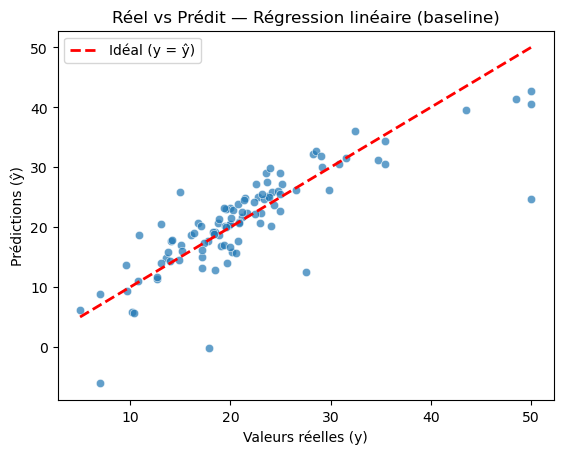

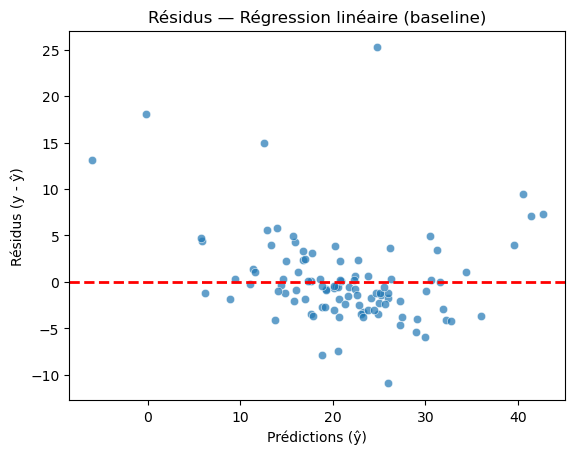

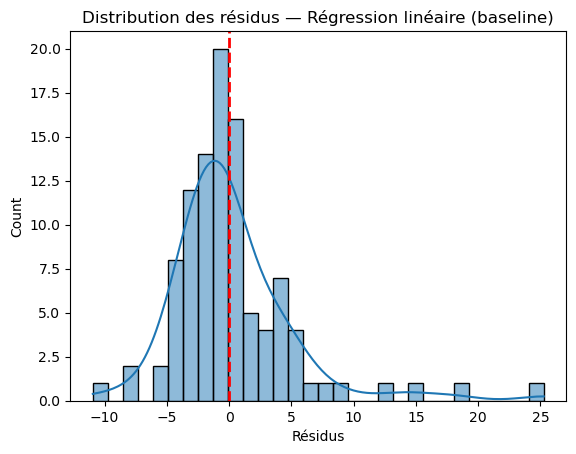

In [16]:
# ---- Modèle baseline linéaire (toutes les features) ----
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Sécurité: mêmes colonnes train/test
assert list(X_train.columns) == list(X_test.columns)

baseline_lin = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

baseline_lin.fit(X_train.astype(float), y_train.astype(float))
y_pred = baseline_lin.predict(X_test.astype(float))

# Résidus
residus = y_test - y_pred

# 1) Réel vs Prédit
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="Idéal (y = ŷ)")
plt.xlabel("Valeurs réelles (y)")
plt.ylabel("Prédictions (ŷ)")
plt.title("Réel vs Prédit — Régression linéaire (baseline)")
plt.legend(); plt.show()

# 2) Résidus vs Prédictions
sns.scatterplot(x=y_pred, y=residus, alpha=0.7)
plt.axhline(0, color="red", linestyle="--", lw=2)
plt.xlabel("Prédictions (ŷ)")
plt.ylabel("Résidus (y - ŷ)")
plt.title("Résidus — Régression linéaire (baseline)")
plt.show()

# 3) Distribution des résidus
sns.histplot(residus, kde=True, bins=30)
plt.axvline(0, color="red", linestyle="--", lw=2)
plt.xlabel("Résidus")
plt.title("Distribution des résidus — Régression linéaire (baseline)")
plt.show()


#### 📊 Interprétation des graphiques (régression linéaire baseline)

1. **Valeurs réelles vs Prédictions**
   - La majorité des points se rapprochent bien de la diagonale rouge (ligne idéale y = ŷ).  
   - Cela montre que le modèle parvient à capturer la tendance générale des prix des maisons.  
   - On note néanmoins une certaine dispersion, surtout pour les valeurs extrêmes.

2. **Résidus vs Prédictions**
   - Les résidus (erreurs) sont globalement centrés autour de 0, ce qui est une bonne chose.  
   - Mais on observe une légère structure : les résidus ne sont pas totalement aléatoires.  
   - Cela suggère que le modèle linéaire ne capture pas parfaitement toutes les relations entre variables et cible.

3. **Distribution des résidus**
   - La distribution est à peu près centrée sur 0 → signe que le modèle n’a pas de biais majeur.  
   - On observe cependant une asymétrie et quelques grandes erreurs (résidus > 15 ou < -10).  
   - Cela indique que certains points atypiques (outliers) ou relations non linéaires ne sont pas bien modélisés.

#### ✅ Conclusion
- Le modèle linéaire baseline fait un travail **correct** : il explique une bonne partie de la variance (R² ≈ 0.67).  
- Cependant, il reste des marges d’amélioration, en particulier pour gérer les valeurs extrêmes et les non-linéarités.  
- Ces graphiques confirment que la régression linéaire est une bonne première étape, mais pas parfaite.


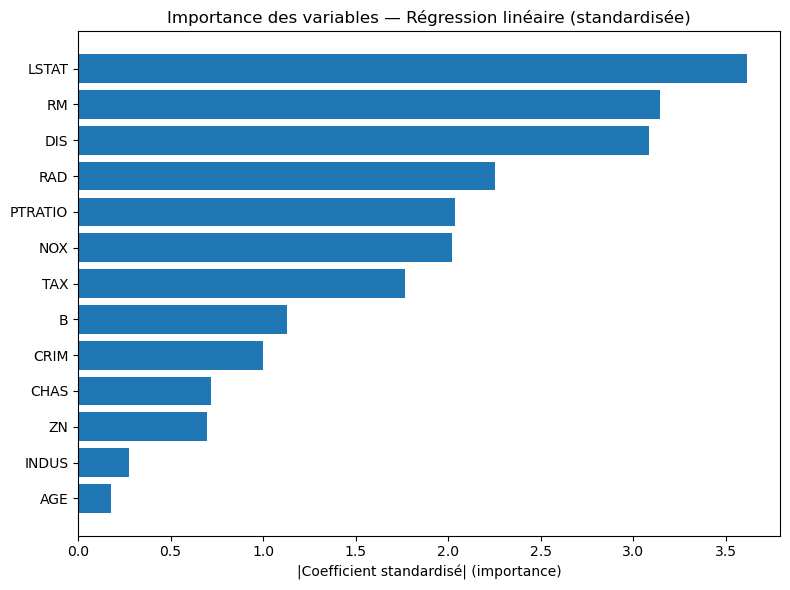

,feature,coef,importance_abs
12,LSTAT,-3.611658,3.611658
5,RM,3.145240,3.145240
7,DIS,-3.081908,3.081908
8,RAD,2.251407,2.251407
10,PTRATIO,-2.037752,2.037752
4,NOX,-2.022319,2.022319
9,TAX,-1.767014,1.767014
11,B,1.129568,1.129568
0,CRIM,-1.002135,1.002135
3,CHAS,0.718738,0.718738


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# --- Données ---
X_train = X_train.astype(float)
X_test  = X_test.astype(float)

# --- Pipeline linéaire avec standardisation ---
lin_std = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

lin_std.fit(X_train, y_train)

# --- Récupérer les "importances" = coefficients sur variables standardisées ---
coefs = lin_std.named_steps["model"].coef_
feat_names = X_train.columns

imp = (pd.DataFrame({
    "feature": feat_names,
    "coef": coefs,
    "importance_abs": np.abs(coefs)
})
 .sort_values("importance_abs", ascending=True))

# --- Affichage en barres (valeur absolue) ---
plt.figure(figsize=(8,6))
plt.barh(imp["feature"], imp["importance_abs"])
plt.xlabel("|Coefficient standardisé| (importance)")
plt.title("Importance des variables — Régression linéaire (standardisée)")
plt.tight_layout()
plt.show()

# Afficher aussi un tableau lisible (avec signe du coefficient)
imp_sorted = imp.sort_values("importance_abs", ascending=False)[["feature","coef","importance_abs"]]
imp_sorted.head(10)


#### 📊 Interprétation des importances des variables (régression linéaire)

1. **Variables les plus influentes**
   - **LSTAT (pourcentage de population à bas revenus)** : c’est la variable la plus déterminante, avec une relation **négative** (plus LSTAT est élevé → prix des maisons plus bas).  
   - **RM (nombre moyen de chambres)** : influence fortement **positivement** les prix → plus il y a de chambres, plus les maisons sont chères.  
   - **DIS (distance aux centres d’emploi)** : impact important (plutôt positif), suggère que l’accessibilité influence aussi les prix.

2. **Variables avec influence modérée**
   - **RAD (accessibilité aux axes routiers), PTRATIO (ratio élèves/professeurs), NOX (pollution)** et **TAX (impôts fonciers)** ont un poids non négligeable.  
   - Ces variables reflètent des aspects structurels (transport, éducation, environnement) qui influencent aussi la valeur immobilière.

3. **Variables moins influentes**
   - **CRIM (criminalité), CHAS (proximité rivière), ZN (zones résidentielles), INDUS (zones industrielles), AGE (ancienneté des logements)** apparaissent avec une importance plus faible dans ce modèle linéaire.  
   - Cela ne veut pas dire qu’elles n’ont aucun effet, mais que leur impact est moins direct ou bien déjà capturé par d’autres variables.

---

✅ **Conclusion** :  
La régression linéaire confirme les intuitions : les prix des maisons à Boston dépendent surtout du niveau socio-économique (LSTAT), de la taille des logements (RM), et de l’accessibilité (DIS, RAD). Les autres variables jouent un rôle secondaire.  
Cela illustre bien l’intérêt d’analyser les **coefficients standardisés** : on peut hiérarchiser les variables et comprendre **quelles caractéristiques expliquent le plus la valeur des maisons**.


#### Comparer avec un modèle d’arbre 

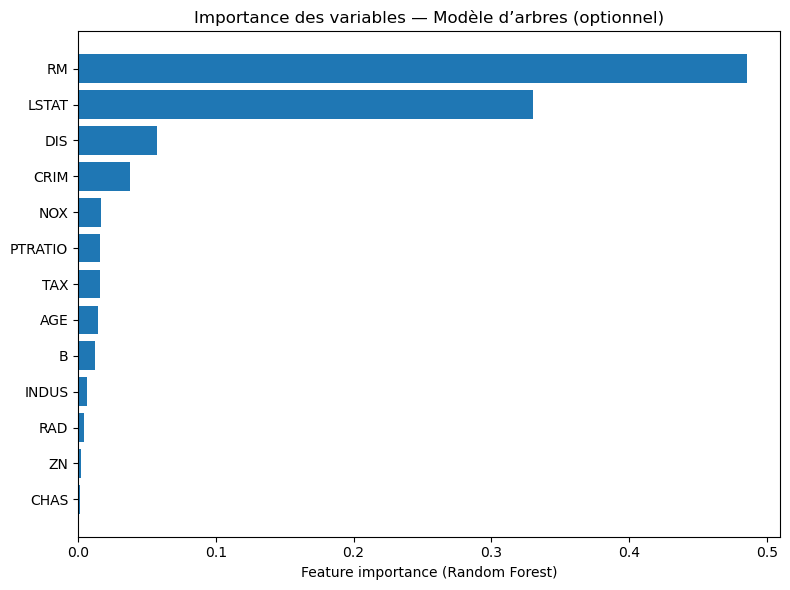

In [19]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42, n_estimators=300)
rf.fit(X_train, y_train)

imp_rf = (pd.DataFrame({
    "feature": X_train.columns,
    "importance": rf.feature_importances_
})
 .sort_values("importance", ascending=True))

plt.figure(figsize=(8,6))
plt.barh(imp_rf["feature"], imp_rf["importance"])
plt.xlabel("Feature importance (Random Forest)")
plt.title("Importance des variables — Modèle d’arbres (optionnel)")
plt.tight_layout()
plt.show()


#### 📊 Interprétation des importances (Random Forest)

1. **Variables dominantes**
   - **RM (nombre moyen de chambres)** : c’est de loin la variable la plus importante. Cela confirme qu’un logement avec plus de chambres est fortement associé à un prix plus élevé.  
   - **LSTAT (population à bas revenus)** : deuxième facteur clé, avec une influence majeure sur la valeur des maisons.  

2. **Variables secondaires**
   - **DIS (distance aux pôles d’emploi)** : joue un rôle modéré, ce qui reflète l’importance de l’accessibilité dans l’immobilier.  
   - **CRIM (taux de criminalité)** : contribue aussi, mais beaucoup moins que RM et LSTAT.  

3. **Variables mineures**
   - Les autres variables (**NOX, PTRATIO, TAX, AGE, etc.**) ont une importance relativement faible dans ce modèle.  
   - Cela signifie que le Random Forest, en explorant automatiquement les interactions complexes, juge que ces variables expliquent peu de variance supplémentaire par rapport aux plus fortes.

---

✅ **Conclusion** :  
- Contrairement à la régression linéaire, où plusieurs variables ont un poids notable, le Random Forest concentre presque toute l’explication sur **RM** et **LSTAT**.  
- Cela illustre bien une différence entre les modèles :  
  - **Régression linéaire** → prend en compte les contributions linéaires de plusieurs variables.  
  - **Arbres/Forêts** → identifient rapidement les variables clés et s’appuient fortement dessus.  


## 🏁 Conclusion

Dans ce laboratoire, nous avons parcouru **les étapes principales d’un projet de Machine Learning supervisé** appliqué à la régression :  

1. **Exploration et Analyse des Données (EDA)**  
   - Étudier les distributions, détecter les outliers, analyser les corrélations.  
   - Comprendre le sens métier des variables (ex. LSTAT, RM).  

2. **Préparation des données**  
   - Séparer en train/test.  
   - Standardiser les variables pour rendre les coefficients comparables.  

3. **Modélisation**  
   - Mise en place d’un modèle de régression linéaire simple (baseline).  
   - Évaluation avec plusieurs métriques (MAE, RMSE, R²).  
   - Comparaison avec d’autres modèles plus complexes (arbres, forêts, boosting).  

4. **Validation**  
   - Introduction à la validation croisée pour mesurer la robustesse du modèle.  

5. **Interprétation**  
   - Analyse des résidus pour vérifier les hypothèses du modèle.  
   - Étude de l’importance des variables pour comprendre les facteurs clés.  

---

### 🚧 Ce que nous n’avons pas encore couvert (mais qui viendra dans la suite) :

- **Feature Engineering avancé** :  
  création de nouvelles variables, transformation non linéaire, interaction entre features.  

- **Hyperparameter Tuning (Fine Tuning)** :  
  optimisation des paramètres (GridSearch, RandomSearch, etc.) pour améliorer les modèles.  

- **Déploiement** :  
  mettre un modèle en production (API, application, monitoring des performances).  

---

👉 **Ce laboratoire avait pour objectif de donner une première vision claire et pratique** :  
comment passer des données brutes à un modèle simple, comprendre ses limites, et commencer à interpréter les résultats.  

Dans les **prochaines sessions labs**, nous irons plus loin pour :  
- améliorer nos modèles avec du **feature engineering**,  
- explorer des **méthodes de fine tuning**,  
- et aborder la **mise en production des modèles**.  

⚡ En résumé : aujourd’hui nous avons posé les bases, et la suite de la formation apportera les outils pour aller du prototype jusqu’à un modèle réellement opérationnel.
